In [11]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pandas as pd
from pprint import pprint
import string
import os
import re
import  sys
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from textblob import TextBlob


In [13]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

In [14]:
data_loader = SlackDataLoader("../data")

def get_channel_messages(channel):
    channel_messages = utils.get_messages_on_channel(f"../data/{channel}") 
    # Create an empty DataFrame
    df = pd.DataFrame(channel_messages)
    return df

def get_all_channels_message():
    dfs = []  # List to store individual DataFrames

    for channel in data_loader.channels:
        dfs.append(get_channel_messages(channel["name"]))

    # Concatenate all DataFrames into a single DataFrame
    result_df = pd.concat(dfs, ignore_index=True)

    return result_df

In [15]:
def preprocess_text(text):
    # Extract and remove URLs
    urls = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
    for url in urls:
        text = text.replace(url, '')

    text = re.sub(r'<@.*?>', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the tokens back into a string
    text = ' '.join(tokens)

    return text


In [16]:
df = get_all_channels_message()
df['cleaned_text'] = df['text'].apply(preprocess_text)


In [17]:
# Ensure the "ts" column is in a datetime format
df['ts'] = pd.to_datetime(df['ts'], unit='s')

In [33]:
# Group messages by day since the start of the training
df['day'] = df['ts'].dt.date
grouped_data = df.groupby('day')['cleaned_text'].agg(lambda x: ' '.join(x)).reset_index()

In [34]:
grouped_data.head()

,day,cleaned_text
0,2022-08-12,join channel join channel join channel join ch...
1,2022-08-18,join channel join channel join channel join ch...
2,2022-08-19,join channel join channel join channel join ch...
3,2022-08-20,join channel join channel join channel join ch...
4,2022-08-21,hi look forward start togeth tomorrow hello ev...


In [37]:
# Define a function to get sentiment polarity and subjectivity
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity



In [38]:
# Apply sentiment analysis to the aggregated messages
grouped_data[['sentiment_polarity', 'sentiment_subjectivity']] = grouped_data['cleaned_text'].apply(lambda x: pd.Series(get_sentiment(x)))


In [39]:
grouped_data.head()

,day,cleaned_text,sentiment_polarity,sentiment_subjectivity
0,2022-08-12,join channel join channel join channel join ch...,0.000000,0.00
1,2022-08-18,join channel join channel join channel join ch...,0.000000,0.00
2,2022-08-19,join channel join channel join channel join ch...,0.000000,0.00
3,2022-08-20,join channel join channel join channel join ch...,0.560000,0.95
4,2022-08-21,hi look forward start togeth tomorrow hello ev...,0.566667,1.00


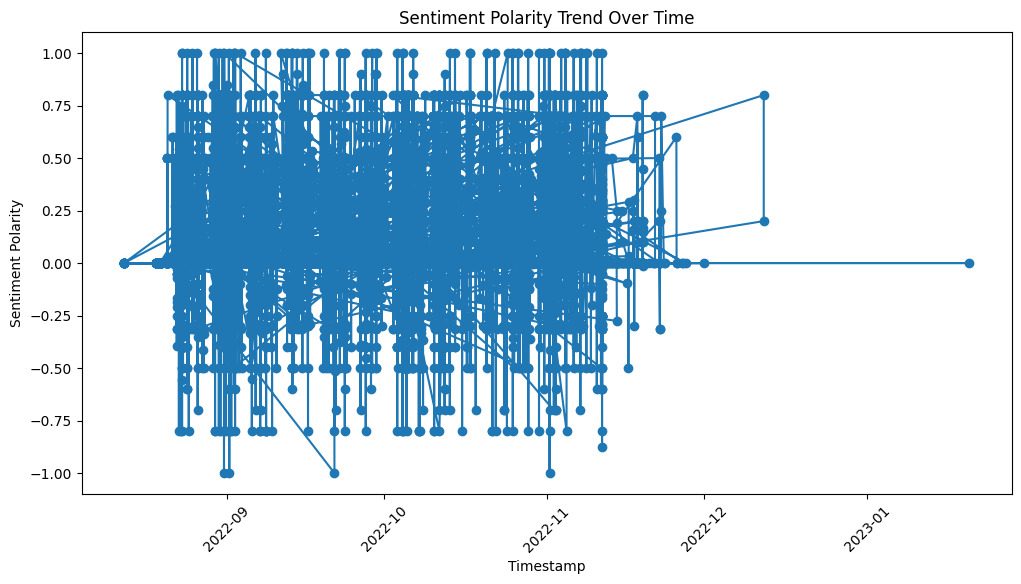

In [41]:
# Visualize the Time Series Trend for Sentiment Polarity
plt.figure(figsize=(12, 6))
plt.plot(df['ts'], df['sentiment_polarity'], marker='o')
plt.title('Sentiment Polarity Trend Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Sentiment Polarity')
plt.xticks(rotation=45)
plt.show()

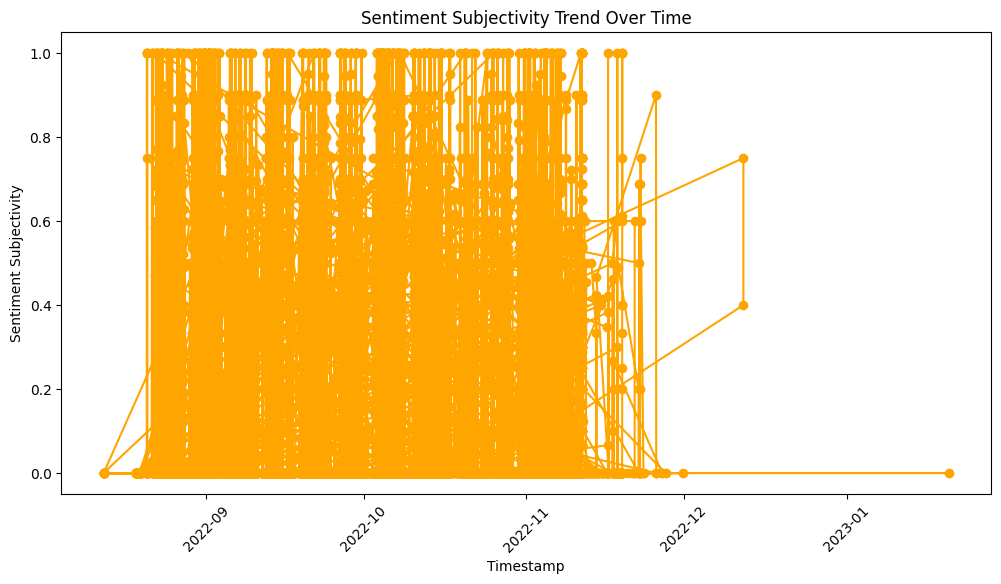

In [42]:
# Visualize the Time Series Trend for Sentiment Subjectivity
plt.figure(figsize=(12, 6))
plt.plot(df['ts'], df['sentiment_subjectivity'], marker='o', color='orange')
plt.title('Sentiment Subjectivity Trend Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Sentiment Subjectivity')
plt.xticks(rotation=45)
plt.show()


In [44]:

def label_sentiments_in_dataframe(df, sentiment_polarity_column='sentiment_polarity', sentiment_subjectivity_column='sentiment_subjectivity'):
    def label_sentiment(row):
        # Extracting polarity and subjectivity from the columns
        polarity = row[sentiment_polarity_column]
        subjectivity = row[sentiment_subjectivity_column]

        # Detailed sentiment classification
        if polarity > 0.5 and subjectivity > 0.6:
            detailed_label = 'Strong Positive Opinion'
        elif 0.1 < polarity <= 0.5 and subjectivity > 0.6:
            detailed_label = 'Mild Positive Opinion'
        elif polarity > 0.5 and subjectivity < 0.4:
            detailed_label = 'Positive Fact'
        elif -0.1 <= polarity <= 0.1 and subjectivity > 0.6:
            detailed_label = 'Neutral Opinion'
        elif -0.1 <= polarity <= 0.1 and subjectivity < 0.4:
            detailed_label = 'Neutral Fact'
        elif -0.5 < polarity <= -0.1 and subjectivity > 0.6:
            detailed_label = 'Mild Negative Opinion'
        elif polarity < -0.5 and subjectivity > 0.6:
            detailed_label = 'Strong Negative Opinion'
        elif polarity < -0.5 and subjectivity < 0.4:
            detailed_label = 'Negative Fact'
        else:
            detailed_label = 'Negative Fact'

        # Mapping detailed categories to broader Positive, Neutral, Negative
        if 'Positive' in detailed_label:
            return 'Positive'
        elif 'Negative' in detailed_label:
            return 'Negative'
        elif 'Neutral' in detailed_label:
            return 'Neutral'
        else:
            return 'Unclassified'

    df['Label'] = df.apply(label_sentiment, axis=1)
    return df

In [105]:
df_labeled.head()

,day,cleaned_text,sentiment_polarity,sentiment_subjectivity,Label
0,2022-08-12,join channel join channel join channel join ch...,0.000000,0.00,Neutral
1,2022-08-18,join channel join channel join channel join ch...,0.000000,0.00,Neutral
2,2022-08-19,join channel join channel join channel join ch...,0.000000,0.00,Neutral
3,2022-08-20,join channel join channel join channel join ch...,0.560000,0.95,Positive
4,2022-08-21,hi look forward start togeth tomorrow hello ev...,0.566667,1.00,Positive


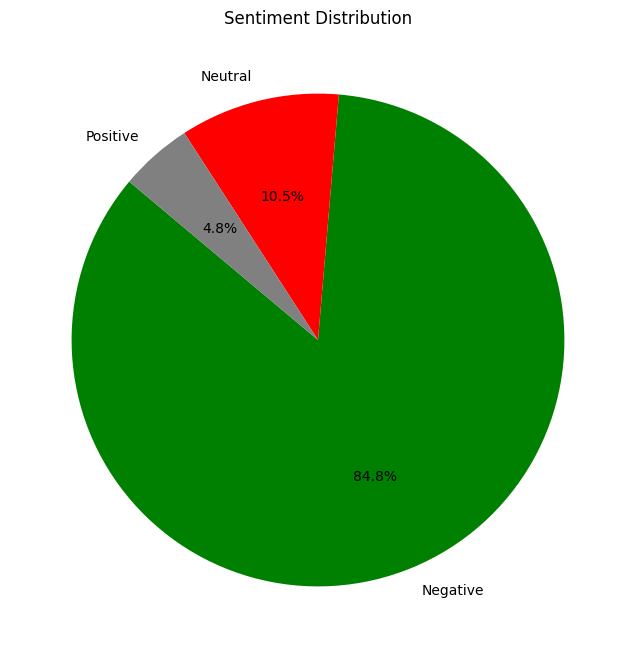

In [47]:
label_counts = df_labeled['Label'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['green', 'red', 'grey'])
plt.title('Sentiment Distribution')
plt.show()